# **Dependencies**

In [ ]:
pip install transformers

In [2]:
import tensorflow as tf

from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
os.environ["WANDB_API_KEY"] = "0"

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [7]:
max_length = 200
batch_size = 32
# dev_size = 0.25

In [8]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

### **Dataset Preparation**

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [10]:
df = pd.read_csv('Fincorp.csv')
df = df.sample(frac = 1)

**Label Encoding**

In [11]:
df['Emotion'] = le.fit_transform(df['Emotion'])
df['Severity level'] = le.fit_transform(df['Severity level'])
df['Sentiment'] = le.fit_transform(df['Sentiment'])
df['Emotion'] = le.fit_transform(df['Emotion'])

In [12]:
df

,Domain,Complaint/ Opinion,Complaint Label,Severity level,Sentiment,Emotion
5568,Stocks and investment,Masks for Educators Mutual Aid Fund just bough...,0,4,2,3
129,Transaction Fail,@HDFCBank_Cares my issue related to loading an...,1,3,0,5
2196,Tax,"@IncomeTaxIndia Dear Team, I filled the return...",1,2,0,5
1752,Transaction Failure,@CryptoZyte_News @CryptoPieceNFT Is blockchain...,1,3,1,4
3996,Crypto,@TheHouseOfTrad1 @JasonPLowery The problem is ...,0,4,1,5
...,...,...,...,...,...,...
658,Customer Service,"@TheOfficialSBI Hello Team, Again I'm facing a...",1,2,0,5
3819,Stock,@NoMoreHeroes451 If you view BTC as property a...,0,4,2,3
4565,Economy,October-December sugar output up 4.75 at 115....,0,4,2,3
1590,ATM,@ChaseSupport are ATM and debit card services ...,1,1,0,5


### **Tokenization (RoBERTa)**

In [13]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,  test_size=0.3, shuffle=True, random_state=42)

In [15]:
df_train, df_val = train_test_split(df_train,  test_size=0.15, shuffle=True, random_state=42)

In [16]:
train_encoded = bert_encode(df_train['Complaint/ Opinion'].values.tolist())

In [17]:
train_encoded.numpy().shape

(3736, 200)

In [18]:
test_encoded = bert_encode(df_test['Complaint/ Opinion'].values.tolist())

In [19]:
test_encoded.numpy().shape

(1885, 200)

In [20]:
val_encoded = bert_encode(df_val['Complaint/ Opinion'].values.tolist())

### **Creating Batched Dataset**

In [10]:
# For Single task experiments
def gen_data1(x,y,batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text , emo = x[index], y[index]

      x_batch[i] = text
      y_batch[i] = emo

    yield x_batch, y_batch

# For Bi-task Experiments
def gen_data2(x,y,z, batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))
    z_batch = np.zeros((batch_size, ))  

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text, comp, sev= x[index], y[index], z[index]

      x_batch[i] = text
      y_batch[i] = comp
      z_batch[i] = sev

    yield x_batch, [y_batch, z_batch]

# For Tri-task Experiments
def gen_data3(x,y,z, p, batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))
    z_batch = np.zeros((batch_size, ))
    p_batch = np.zeros((batch_size, ))    

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text, comp, sev, sent = x[index], y[index], z[index], p[index]

      x_batch[i] = text
      y_batch[i] = comp
      z_batch[i] = sev
      p_batch[i] = sent

    yield x_batch, [y_batch, z_batch, p_batch]

# For MTL experiments, ie all 4 tasks together
def gen_data4(x,y,z, p, q, batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))
    z_batch = np.zeros((batch_size, ))
    p_batch = np.zeros((batch_size, ))
    q_batch = np.zeros((batch_size, ))

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text, comp, sev, sent, emo = x[index], y[index], z[index], p[index], q[index]

      x_batch[i] = text
      y_batch[i] = comp
      z_batch[i] = sev
      p_batch[i] = sent
      q_batch[i] = emo

    yield x_batch, [y_batch, z_batch, p_batch, q_batch]

In [11]:
# Non-shuffled batches for getting the predictions on testing data and Macro F1 score calculation
def gen_data_mtl(x,y,z, p,q, batch_size= 32):

  xbatched = []
  ybatched = []
  zbatched = []
  pbatched = []
  qbatched = []


  num_examples = len(y)
  num = len(x)//batch_size
  i = 1

  while (i<num):

    xbatched.append(x[32*i:32*(i+1)])
    ybatched.append(y[32*i:32*(i+1)])
    zbatched.append(z[32*i:32*(i+1)])
    pbatched.append(p[32*i:32*(i+1)])
    qbatched.append(q[32*i:32*(i+1)])
    i+=1
  
  return xbatched, [ybatched, zbatched, pbatched, qbatched]

# Non-shuffled batches
def gen_data_tri(x,y,z, p, batch_size= 32):

  xbatched = []
  ybatched = []
  zbatched = []
  pbatched = []


  num_examples = len(y)
  num = len(x)//batch_size
  i = 1

  while (i<num):

    xbatched.append(x[32*i:32*(i+1)])
    ybatched.append(y[32*i:32*(i+1)])
    zbatched.append(z[32*i:32*(i+1)])
    pbatched.append(p[32*i:32*(i+1)])
    i+=1
  
  return xbatched, [ybatched, zbatched, pbatched]  

In [23]:
train_er = gen_data4(train_encoded.numpy(),
                     df_train['Complaint Label'].values ,
                     df_train['Severity level'].values, 
                     df_train['Sentiment'].values,
                     df_train['Emotion'].values)

In [24]:
test_er = gen_data4(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [25]:
val_er = gen_data4(val_encoded.numpy(),
                   df_val['Complaint Label'].values ,
                   df_val['Severity level'].values, 
                   df_val['Sentiment'].values,
                   df_val['Emotion'].values)

# **Model Building**

In [12]:
from transformers import TFAutoModel
bert_encoder = TFAutoModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [13]:
def bert_tweets_model_quad():

    # Shared Layers - 1. RoBERTa embeddings 2. BiGRU layer 
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = Bidirectional(tf.keras.layers.GRU(100, dropout=0.3, recurrent_dropout=0.3))(last_hidden_states)

    # Sentiment detection task (Auxiliary Task)
    output3 = tf.keras.layers.Dense(3, activation='softmax', name='sent')(x)

    # Emotion Detection task (Auxiliary Task)
    output4 = tf.keras.layers.Dense(7, activation='softmax', name='emo')(x)

    # Severity Detection Task with information from Auxiliary tasks fed
    add = tf.keras.layers.Concatenate(axis=1)([x, output3, output4])
    output2 = tf.keras.layers.Dense(5, activation='softmax', name='sev')(add)

    # Complaint Detection Task with information from Auxiliary tasks fed
    add = tf.keras.layers.Concatenate(axis=1)([x, output3 , output4])
    output1 = tf.keras.layers.Dense(1, activation='sigmoid', name='comp')(add)

    model = tf.keras.Model(inputs=input_word_ids, outputs=[output1,output2,output3, output4])
    
    return model

In [14]:
model_diag = bert_tweets_model_quad()

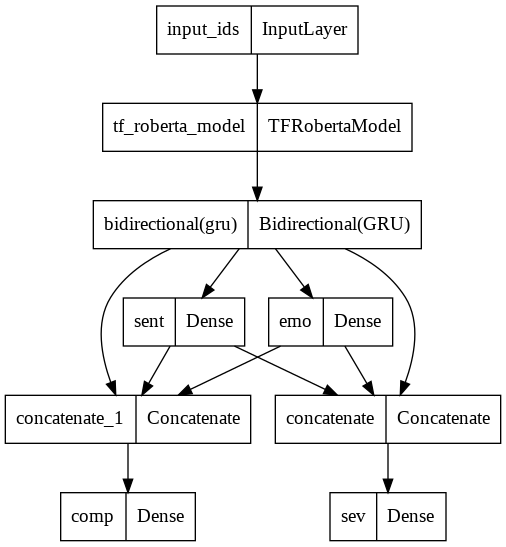

In [15]:
tf.keras.utils.plot_model(model_diag)

# **Final Execution**

## **Experiment 1**

In [ ]:
model = bert_tweets_model_quad()

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

losses = {
"comp": "binary_crossentropy",
"sev": "sparse_categorical_crossentropy",
"sent": "sparse_categorical_crossentropy",
"emo": "sparse_categorical_crossentropy"
}

lossWeights = {"comp": 1.0, "sev": 1.0, "sent":0.5, "emo":0.5}
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

# train the model
_ = model.fit(
    train_er,
    validation_data = val_er,
    steps_per_epoch = 150, 
    validation_steps = 100,
    epochs = 3,
    verbose = True
    )

# validate the model


Epoch 1/3


150/150 [==============================] - 455s 3s/step - loss: 2.9797 - comp_loss: 0.5650 - sev_loss: 1.1433 - sent_loss: 0.9224 - emo_loss: 1.6204 - comp_accuracy: 0.6821 - sev_accuracy: 0.5483 - sent_accuracy: 0.5852 - emo_accuracy: 0.4150 - val_loss: 2.0451 - val_comp_loss: 0.2297 - val_sev_loss: 0.7951 - val_sent_loss: 0.7273 - val_emo_loss: 1.3134 - val_comp_accuracy: 0.9228 - val_sev_accuracy: 0.7019 - val_sent_accuracy: 0.6791 - val_emo_accuracy: 0.5256
Epoch 2/3
150/150 [==============================] - 429s 3s/step - loss: 2.0352 - comp_loss: 0.2266 - sev_loss: 0.7540 - sent_loss: 0.7238 - emo_loss: 1.3854 - comp_accuracy: 0.9152 - sev_accuracy: 0.7108 - sent_accuracy: 0.6723 - emo_accuracy: 0.5052 - val_loss: 1.6169 - val_comp_loss: 0.1196 - val_sev_loss: 0.6020 - val_sent_loss: 0.5846 - val_emo_loss: 1.2060 - val_comp_accuracy: 0.9506 - val_sev_accuracy: 0.7709 - val_sent_accuracy: 0.7366 - val_emo_accuracy: 0.5544
Epoch 3/3
150/150 [==============================] - 428s 

In [ ]:
acc = model.evaluate(test_er, steps = 100, verbose = True)

100/100 [==============================] - 55s 547ms/step - loss: 1.3674 - comp_loss: 0.0777 - sev_loss: 0.4716 - sent_loss: 0.5201 - emo_loss: 1.1161 - comp_accuracy: 0.9772 - sev_accuracy: 0.8359 - sent_accuracy: 0.7675 - emo_accuracy: 0.6003


In [ ]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
test_pred_data

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def macrof1s(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

acc1 = []
mfs1 = []
acc2 = []
mfs2 = []
acc3 = []
mfs3 = []
acc4 = []
mfs4 = []

for idx in range(len(test_pred_data)):
  yp1, zp1, pp1, qp1 = model.predict(test_pred_data[idx])

  yp2 = []
  for i in yp1:
    if(i>0.5):
      yp2.append(1)
    else:
      yp2.append(0)

  zp2 = zp1.argmax(axis = -1)
  pp2 = pp1.argmax(axis = -1)
  qp2 = qp1.argmax(axis = -1)

  acc1.append(accuracy_score(yp2, y_pred[idx]))
  acc2.append(accuracy_score(zp2, z_pred[idx]))
  acc3.append(accuracy_score(pp2, p_pred[idx]))
  acc4.append(accuracy_score(qp2, q_pred[idx]))


  mfs1.append(f1_score(yp2, y_pred[idx], average='macro'))
  mfs2.append(f1_score(zp2, z_pred[idx], average='macro'))
  mfs3.append(f1_score(pp2, p_pred[idx], average='macro'))
  mfs4.append(f1_score(qp2, q_pred[idx], average='macro'))


### **Final Macro F1 Score and Testing Accuracy**

In [ ]:
#Complaint Detection Task -
print("Accuracy : ", sum(acc1)/len(acc1))
print("Macro F1 Score : ", sum(mfs1)/len(mfs1))

Accuracy :  0.9714912280701754
Macro F1 Score :  0.9706010936955747


In [ ]:
#Severity Detection Task -
print("Accuracy : ", sum(acc2)/len(acc2))
print("Macro F1 Score : ", sum(mfs2)/len(mfs2))

Accuracy :  0.8305921052631579
Macro F1 Score :  0.6702400508656867


In [ ]:
#Sentiment Detection Task -
print("Accuracy : ", sum(acc3)/len(acc3))
print("Macro F1 Score : ", sum(mfs3)/len(mfs3))

Accuracy :  0.7774122807017544
Macro F1 Score :  0.6760976696429579


In [ ]:
#Emotion Detection Task -
print("Accuracy : ", sum(acc4)/len(acc4))
print("Macro F1 Score : ", sum(mfs4)/len(mfs4))

Accuracy :  0.5910087719298246
Macro F1 Score :  0.3457996052470952


## **Experiment 2**

In [ ]:
model = bert_tweets_model_quad()

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

losses = {
"comp": "binary_crossentropy",
"sev": "sparse_categorical_crossentropy",
"sent": "sparse_categorical_crossentropy",
"emo": "sparse_categorical_crossentropy"
}

lossWeights = {"comp": 1.0, "sev": 1.0, "sent":0.5, "emo":0.5}
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

# train the model
_ = model.fit(
    train_er,
    validation_data = val_er,
    steps_per_epoch = 150, 
    validation_steps = 100,
    epochs = 3,
    verbose = True
    )

# validate the model


Epoch 1/3


150/150 [==============================] - 439s 3s/step - loss: 2.7999 - comp_loss: 0.4996 - sev_loss: 1.0814 - sent_loss: 0.8953 - emo_loss: 1.5426 - comp_accuracy: 0.7327 - sev_accuracy: 0.5775 - sent_accuracy: 0.5915 - emo_accuracy: 0.4508 - val_loss: 2.1622 - val_comp_loss: 0.2702 - val_sev_loss: 0.8045 - val_sent_loss: 0.7531 - val_emo_loss: 1.4218 - val_comp_accuracy: 0.9144 - val_sev_accuracy: 0.6944 - val_sent_accuracy: 0.6609 - val_emo_accuracy: 0.5122
Epoch 2/3
150/150 [==============================] - 399s 3s/step - loss: 1.8228 - comp_loss: 0.1652 - sev_loss: 0.6778 - sent_loss: 0.6773 - emo_loss: 1.2823 - comp_accuracy: 0.9408 - sev_accuracy: 0.7371 - sent_accuracy: 0.6883 - emo_accuracy: 0.5417 - val_loss: 1.8258 - val_comp_loss: 0.1805 - val_sev_loss: 0.6824 - val_sent_loss: 0.6687 - val_emo_loss: 1.2572 - val_comp_accuracy: 0.9484 - val_sev_accuracy: 0.7563 - val_sent_accuracy: 0.6966 - val_emo_accuracy: 0.5572
Epoch 3/3
150/150 [==============================] - 398s 

In [ ]:
acc = model.evaluate(test_er, steps = 100, verbose = True)

100/100 [==============================] - 40s 404ms/step - loss: 1.6854 - comp_loss: 0.1494 - sev_loss: 0.6301 - sent_loss: 0.6125 - emo_loss: 1.1993 - comp_accuracy: 0.9528 - sev_accuracy: 0.7734 - sent_accuracy: 0.7387 - emo_accuracy: 0.5609


In [ ]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
test_pred_data

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def macrof1s(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

acc1 = []
mfs1 = []
acc2 = []
mfs2 = []
acc3 = []
mfs3 = []
acc4 = []
mfs4 = []

for idx in range(len(test_pred_data)):
  yp1, zp1, pp1, qp1 = model.predict(test_pred_data[idx])

  yp2 = []
  for i in yp1:
    if(i>0.5):
      yp2.append(1)
    else:
      yp2.append(0)

  zp2 = zp1.argmax(axis = -1)
  pp2 = pp1.argmax(axis = -1)
  qp2 = qp1.argmax(axis = -1)

  acc1.append(accuracy_score(yp2, y_pred[idx]))
  acc2.append(accuracy_score(zp2, z_pred[idx]))
  acc3.append(accuracy_score(pp2, p_pred[idx]))
  acc4.append(accuracy_score(qp2, q_pred[idx]))


  mfs1.append(f1_score(yp2, y_pred[idx], average='macro'))
  mfs2.append(f1_score(zp2, z_pred[idx], average='macro'))
  mfs3.append(f1_score(pp2, p_pred[idx], average='macro'))
  mfs4.append(f1_score(qp2, q_pred[idx], average='macro'))


### **Final Macro F1 Score and Testing Accuracy**

In [ ]:
#Complaint Detection Task -
print("Accuracy : ", sum(acc1)/len(acc1))
print("Macro F1 Score : ", sum(mfs1)/len(mfs1))

Accuracy :  0.9605263157894737
Macro F1 Score :  0.9596241690302442


In [ ]:
#Severity Detection Task -
print("Accuracy : ", sum(acc2)/len(acc2))
print("Macro F1 Score : ", sum(mfs2)/len(mfs2))

Accuracy :  0.7933114035087719
Macro F1 Score :  0.6193297948156415


In [ ]:
#Sentiment Detection Task -
print("Accuracy : ", sum(acc3)/len(acc3))
print("Macro F1 Score : ", sum(mfs3)/len(mfs3))

Accuracy :  0.7286184210526315
Macro F1 Score :  0.6029974742070241


In [ ]:
#Emotion Detection Task -
print("Accuracy : ", sum(acc4)/len(acc4))
print("Macro F1 Score : ", sum(mfs4)/len(mfs4))

Accuracy :  0.5597587719298246
Macro F1 Score :  0.2670919708824191


## **Experiment 3**

In [ ]:
df = pd.read_csv('Fincorp.csv')
df = df.sample(frac = 1)

**Label Encoding**

In [ ]:
df['Emotion'] = le.fit_transform(df['Emotion'])
df['Severity level'] = le.fit_transform(df['Severity level'])
df['Sentiment'] = le.fit_transform(df['Sentiment'])
df['Emotion'] = le.fit_transform(df['Emotion'])

In [ ]:
df

,Domain,Complaint/ Opinion,Complaint Label,Severity level,Sentiment,Emotion
4748,Transaction,@Venmo In case @Venmo wants to try out gift-wr...,0,4,2,4
1128,Customer Service,@AmazonHelp @jagograhakjago After raising the ...,1,2,0,1
3856,Crypto,@MorganTBennett @gluk64 @epolynya @jadler0 @er...,0,4,0,1
524,Loan,"@BarclaysUKHelp say I had a business account, ...",1,3,0,2
3209,Credit Card,@mightyteapot Player housing and more guild ha...,0,4,1,4
...,...,...,...,...,...,...
305,Loan,@ICICIBank @ICICIBank_Care @ICICI_Direct @RBI ...,1,1,0,5
5188,Debit card,"Well, good luck with that. You can't do it us...",0,4,0,2
5014,Debit card,"Ugh, I think someone stole my debit card info....",0,4,2,3
4752,Transaction,@Millions @Venmo OMG i would love to have my B...,0,4,2,3


### **Tokenization (RoBERTa)**

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,  test_size=0.3, shuffle=True, random_state=42)

In [ ]:
df_train, df_val = train_test_split(df_train,  test_size=0.15, shuffle=True, random_state=42)

In [ ]:
train_encoded = bert_encode(df_train['Complaint/ Opinion'].values.tolist())

In [ ]:
train_encoded.numpy().shape

(3736, 200)

In [ ]:
test_encoded = bert_encode(df_test['Complaint/ Opinion'].values.tolist())

In [ ]:
test_encoded.numpy().shape

(1885, 200)

In [ ]:
val_encoded = bert_encode(df_val['Complaint/ Opinion'].values.tolist())

In [ ]:
train_er = gen_data4(train_encoded.numpy(),
                     df_train['Complaint Label'].values ,
                     df_train['Severity level'].values, 
                     df_train['Sentiment'].values,
                     df_train['Emotion'].values)

In [ ]:
test_er = gen_data4(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
val_er = gen_data4(val_encoded.numpy(),
                   df_val['Complaint Label'].values ,
                   df_val['Severity level'].values, 
                   df_val['Sentiment'].values,
                   df_val['Emotion'].values)

In [ ]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
model = bert_tweets_model_quad()

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

losses = {
"comp": "binary_crossentropy",
"sev": "sparse_categorical_crossentropy",
"sent": "sparse_categorical_crossentropy",
"emo": "sparse_categorical_crossentropy"
}

lossWeights = {"comp": 1.0, "sev": 1.0, "sent":0.5, "emo":0.5}
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

# train the model
_ = model.fit(
    train_er,
    validation_data = val_er,
    steps_per_epoch = 150, 
    validation_steps = 100,
    epochs = 3,
    verbose = True
    )

# validate the model


Epoch 1/3


150/150 [==============================] - 328s 2s/step - loss: 2.9136 - comp_loss: 0.5338 - sev_loss: 1.1140 - sent_loss: 0.9117 - emo_loss: 1.6197 - comp_accuracy: 0.7150 - sev_accuracy: 0.5627 - sent_accuracy: 0.5821 - emo_accuracy: 0.4177 - val_loss: 2.0474 - val_comp_loss: 0.2593 - val_sev_loss: 0.7392 - val_sent_loss: 0.7404 - val_emo_loss: 1.3574 - val_comp_accuracy: 0.9244 - val_sev_accuracy: 0.7191 - val_sent_accuracy: 0.6544 - val_emo_accuracy: 0.5069
Epoch 2/3
150/150 [==============================] - 307s 2s/step - loss: 1.8475 - comp_loss: 0.1722 - sev_loss: 0.6882 - sent_loss: 0.6761 - emo_loss: 1.2981 - comp_accuracy: 0.9458 - sev_accuracy: 0.7325 - sent_accuracy: 0.6840 - emo_accuracy: 0.5281 - val_loss: 1.7839 - val_comp_loss: 0.1693 - val_sev_loss: 0.6350 - val_sent_loss: 0.7066 - val_emo_loss: 1.2526 - val_comp_accuracy: 0.9513 - val_sev_accuracy: 0.7647 - val_sent_accuracy: 0.6844 - val_emo_accuracy: 0.5319
Epoch 3/3
150/150 [==============================] - 306s 

In [ ]:
acc = model.evaluate(test_er, steps = 100, verbose = True)

100/100 [==============================] - 36s 356ms/step - loss: 1.5905 - comp_loss: 0.1355 - sev_loss: 0.5402 - sent_loss: 0.6152 - emo_loss: 1.2144 - comp_accuracy: 0.9544 - sev_accuracy: 0.8122 - sent_accuracy: 0.7156 - emo_accuracy: 0.5494


In [ ]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def macrof1s(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

acc1 = []
mfs1 = []
acc2 = []
mfs2 = []
acc3 = []
mfs3 = []
acc4 = []
mfs4 = []

for idx in range(len(test_pred_data)):
  yp1, zp1, pp1, qp1 = model.predict(test_pred_data[idx])

  yp2 = []
  for i in yp1:
    if(i>0.5):
      yp2.append(1)
    else:
      yp2.append(0)

  zp2 = zp1.argmax(axis = -1)
  pp2 = pp1.argmax(axis = -1)
  qp2 = qp1.argmax(axis = -1)

  acc1.append(accuracy_score(yp2, y_pred[idx]))
  acc2.append(accuracy_score(zp2, z_pred[idx]))
  acc3.append(accuracy_score(pp2, p_pred[idx]))
  acc4.append(accuracy_score(qp2, q_pred[idx]))


  mfs1.append(f1_score(yp2, y_pred[idx], average='macro'))
  mfs2.append(f1_score(zp2, z_pred[idx], average='macro'))
  mfs3.append(f1_score(pp2, p_pred[idx], average='macro'))
  mfs4.append(f1_score(qp2, q_pred[idx], average='macro'))


### **Final Macro F1 Score and Testing Accuracy**

In [ ]:
#Complaint Detection Task -
print("Accuracy : ", sum(acc1)/len(acc1))
print("Macro F1 Score : ", sum(mfs1)/len(mfs1))

Accuracy :  0.9577850877192983
Macro F1 Score :  0.9560475347536072


In [ ]:
#Severity Detection Task -
print("Accuracy : ", sum(acc2)/len(acc2))
print("Macro F1 Score : ", sum(mfs2)/len(mfs2))

Accuracy :  0.805921052631579
Macro F1 Score :  0.6124473695456621


In [ ]:
#Sentiment Detection Task -
print("Accuracy : ", sum(acc3)/len(acc3))
print("Macro F1 Score : ", sum(mfs3)/len(mfs3))

Accuracy :  0.7105263157894737
Macro F1 Score :  0.598537336615019


In [ ]:
#Emotion Detection Task -
print("Accuracy : ", sum(acc4)/len(acc4))
print("Macro F1 Score : ", sum(mfs4)/len(mfs4))

Accuracy :  0.5444078947368421
Macro F1 Score :  0.2528713177051638


## **Experiment 4**

In [30]:
model = bert_tweets_model_quad()

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

losses = {
"comp": "binary_crossentropy",
"sev": "sparse_categorical_crossentropy",
"sent": "sparse_categorical_crossentropy",
"emo": "sparse_categorical_crossentropy"
}

lossWeights = {"comp": 1.0, "sev": 1.0, "sent":0.5, "emo":0.5}
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

# train the model
_ = model.fit(
    train_er,
    validation_data = val_er,
    steps_per_epoch = 150, 
    validation_steps = 100,
    epochs = 3,
    verbose = True
    )

# validate the model


Epoch 1/3


150/150 [==============================] - 422s 3s/step - loss: 3.2129 - comp_loss: 0.6637 - sev_loss: 1.2257 - sent_loss: 0.9864 - emo_loss: 1.6606 - comp_accuracy: 0.6042 - sev_accuracy: 0.5133 - sent_accuracy: 0.5642 - emo_accuracy: 0.4048 - val_loss: 2.9520 - val_comp_loss: 0.5546 - val_sev_loss: 1.1325 - val_sent_loss: 0.9393 - val_emo_loss: 1.5907 - val_comp_accuracy: 0.7359 - val_sev_accuracy: 0.5684 - val_sent_accuracy: 0.5603 - val_emo_accuracy: 0.4094
Epoch 2/3
150/150 [==============================] - 391s 3s/step - loss: 2.2406 - comp_loss: 0.3236 - sev_loss: 0.8413 - sent_loss: 0.7579 - emo_loss: 1.3935 - comp_accuracy: 0.8619 - sev_accuracy: 0.6821 - sent_accuracy: 0.6550 - emo_accuracy: 0.5113 - val_loss: 1.9353 - val_comp_loss: 0.2380 - val_sev_loss: 0.7646 - val_sent_loss: 0.5727 - val_emo_loss: 1.2927 - val_comp_accuracy: 0.9134 - val_sev_accuracy: 0.7044 - val_sent_accuracy: 0.7484 - val_emo_accuracy: 0.5487
Epoch 3/3
150/150 [==============================] - 391s 

In [31]:
acc = model.evaluate(test_er, steps = 100, verbose = True)

100/100 [==============================] - 40s 402ms/step - loss: 1.5149 - comp_loss: 0.1196 - sev_loss: 0.5568 - sent_loss: 0.5538 - emo_loss: 1.1233 - comp_accuracy: 0.9600 - sev_accuracy: 0.7975 - sent_accuracy: 0.7609 - emo_accuracy: 0.5981


In [32]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [ ]:
test_pred_data

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def macrof1s(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

acc1 = []
mfs1 = []
acc2 = []
mfs2 = []
acc3 = []
mfs3 = []
acc4 = []
mfs4 = []

for idx in range(len(test_pred_data)):
  yp1, zp1, pp1, qp1 = model.predict(test_pred_data[idx])

  yp2 = []
  for i in yp1:
    if(i>0.5):
      yp2.append(1)
    else:
      yp2.append(0)

  zp2 = zp1.argmax(axis = -1)
  pp2 = pp1.argmax(axis = -1)
  qp2 = qp1.argmax(axis = -1)

  acc1.append(accuracy_score(yp2, y_pred[idx]))
  acc2.append(accuracy_score(zp2, z_pred[idx]))
  acc3.append(accuracy_score(pp2, p_pred[idx]))
  acc4.append(accuracy_score(qp2, q_pred[idx]))


  mfs1.append(f1_score(yp2, y_pred[idx], average='macro'))
  mfs2.append(f1_score(zp2, z_pred[idx], average='macro'))
  mfs3.append(f1_score(pp2, p_pred[idx], average='macro'))
  mfs4.append(f1_score(qp2, q_pred[idx], average='macro'))


### **Final Macro F1 Score and Testing Accuracy**

In [35]:
#Complaint Detection Task -
print("Accuracy : ", sum(acc1)/len(acc1))
print("Macro F1 Score : ", sum(mfs1)/len(mfs1))

Accuracy :  0.962171052631579
Macro F1 Score :  0.9610289330882346


In [36]:
#Severity Detection Task -
print("Accuracy : ", sum(acc2)/len(acc2))
print("Macro F1 Score : ", sum(mfs2)/len(mfs2))

Accuracy :  0.7971491228070176
Macro F1 Score :  0.6170619698629656


In [37]:
#Sentiment Detection Task -
print("Accuracy : ", sum(acc3)/len(acc3))
print("Macro F1 Score : ", sum(mfs3)/len(mfs3))

Accuracy :  0.7664473684210527
Macro F1 Score :  0.6676371488613868


In [38]:
#Emotion Detection Task -
print("Accuracy : ", sum(acc4)/len(acc4))
print("Macro F1 Score : ", sum(mfs4)/len(mfs4))

Accuracy :  0.5838815789473685
Macro F1 Score :  0.33419183899441307


## **Experiment 5**

In [16]:
df = pd.read_csv('Fincorp.csv')
df = df.sample(frac = 1)

**Label Encoding**

In [17]:
df['Emotion'] = le.fit_transform(df['Emotion'])
df['Severity level'] = le.fit_transform(df['Severity level'])
df['Sentiment'] = le.fit_transform(df['Sentiment'])
df['Emotion'] = le.fit_transform(df['Emotion'])

In [18]:
df

,Domain,Complaint/ Opinion,Complaint Label,Severity level,Sentiment,Emotion
1199,Customer Service,@AmazonHelp Several times i had connected to y...,1,3,0,5
5599,Stocks and investment,If you want to avoid volatility and steadily c...,0,4,2,4
181,Transaction Fail,Refund for my order on Myntra initiated on 24/...,1,3,0,5
5870,Stocks and investment,"Watch this video to know, if Mutual Funds are ...",0,4,1,4
5077,Debit card,@mackaycartoons @TheSpec you guys in Hamilton ...,0,4,2,3
...,...,...,...,...,...,...
311,Loan,@ICICIBank_Care @ICICIBank @RBI @RBIsays not r...,1,3,0,5
2150,Transaction Failure,@chadflood888 @jaydee_757 You do know that Rip...,1,3,0,5
5935,Stocks and investment,🌓best index funds 2022 🌓Top5 mutual funds for ...,0,4,2,4
2656,Consumer transaction complaints,Dear mr @_Kalyan_K your team of @flipkartsuppo...,1,1,0,0


### **Tokenization (RoBERTa)**

In [19]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,  test_size=0.3, shuffle=True, random_state=42)

In [21]:
df_train, df_val = train_test_split(df_train,  test_size=0.15, shuffle=True, random_state=42)

In [22]:
train_encoded = bert_encode(df_train['Complaint/ Opinion'].values.tolist())

In [23]:
train_encoded.numpy().shape

(3736, 200)

In [24]:
test_encoded = bert_encode(df_test['Complaint/ Opinion'].values.tolist())

In [25]:
test_encoded.numpy().shape

(1885, 200)

In [26]:
val_encoded = bert_encode(df_val['Complaint/ Opinion'].values.tolist())

In [27]:
train_er = gen_data4(train_encoded.numpy(),
                     df_train['Complaint Label'].values ,
                     df_train['Severity level'].values, 
                     df_train['Sentiment'].values,
                     df_train['Emotion'].values)

In [28]:
test_er = gen_data4(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [29]:
val_er = gen_data4(val_encoded.numpy(),
                   df_val['Complaint Label'].values ,
                   df_val['Severity level'].values, 
                   df_val['Sentiment'].values,
                   df_val['Emotion'].values)

In [30]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [31]:
model = bert_tweets_model_quad()

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

losses = {
"comp": "binary_crossentropy",
"sev": "sparse_categorical_crossentropy",
"sent": "sparse_categorical_crossentropy",
"emo": "sparse_categorical_crossentropy"
}

lossWeights = {"comp": 1.0, "sev": 1.0, "sent":0.5, "emo":0.5}
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

# train the model
_ = model.fit(
    train_er,
    validation_data = val_er,
    steps_per_epoch = 150, 
    validation_steps = 100,
    epochs = 3,
    verbose = True
    )

# validate the model


Epoch 1/3


150/150 [==============================] - 333s 2s/step - loss: 3.0254 - comp_loss: 0.5699 - sev_loss: 1.1835 - sent_loss: 0.9442 - emo_loss: 1.5997 - comp_accuracy: 0.6833 - sev_accuracy: 0.5371 - sent_accuracy: 0.5750 - emo_accuracy: 0.4298 - val_loss: 2.3039 - val_comp_loss: 0.3189 - val_sev_loss: 0.8740 - val_sent_loss: 0.7674 - val_emo_loss: 1.4546 - val_comp_accuracy: 0.8684 - val_sev_accuracy: 0.6669 - val_sent_accuracy: 0.6125 - val_emo_accuracy: 0.5181
Epoch 2/3
150/150 [==============================] - 310s 2s/step - loss: 2.0105 - comp_loss: 0.2267 - sev_loss: 0.7783 - sent_loss: 0.7041 - emo_loss: 1.3069 - comp_accuracy: 0.9152 - sev_accuracy: 0.7019 - sent_accuracy: 0.6829 - emo_accuracy: 0.5248 - val_loss: 1.8546 - val_comp_loss: 0.2056 - val_sev_loss: 0.7132 - val_sent_loss: 0.6238 - val_emo_loss: 1.2477 - val_comp_accuracy: 0.9247 - val_sev_accuracy: 0.7431 - val_sent_accuracy: 0.7344 - val_emo_accuracy: 0.5669
Epoch 3/3
150/150 [==============================] - 310s 

In [32]:
acc = model.evaluate(test_er, steps = 100, verbose = True)

100/100 [==============================] - 35s 354ms/step - loss: 1.4820 - comp_loss: 0.1134 - sev_loss: 0.5210 - sent_loss: 0.5477 - emo_loss: 1.1474 - comp_accuracy: 0.9634 - sev_accuracy: 0.7987 - sent_accuracy: 0.7694 - emo_accuracy: 0.5922


In [33]:
test_pred_data,[y_pred,z_pred, p_pred,q_pred] = gen_data_mtl(test_encoded.numpy(),
                    df_test['Complaint Label'].values ,
                    df_test['Severity level'].values ,
                    df_test['Sentiment'].values,
                    df_test['Emotion'].values)

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def macrof1s(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

acc1 = []
mfs1 = []
acc2 = []
mfs2 = []
acc3 = []
mfs3 = []
acc4 = []
mfs4 = []

for idx in range(len(test_pred_data)):
  yp1, zp1, pp1, qp1 = model.predict(test_pred_data[idx])

  yp2 = []
  for i in yp1:
    if(i>0.5):
      yp2.append(1)
    else:
      yp2.append(0)

  zp2 = zp1.argmax(axis = -1)
  pp2 = pp1.argmax(axis = -1)
  qp2 = qp1.argmax(axis = -1)

  acc1.append(accuracy_score(yp2, y_pred[idx]))
  acc2.append(accuracy_score(zp2, z_pred[idx]))
  acc3.append(accuracy_score(pp2, p_pred[idx]))
  acc4.append(accuracy_score(qp2, q_pred[idx]))


  mfs1.append(f1_score(yp2, y_pred[idx], average='macro'))
  mfs2.append(f1_score(zp2, z_pred[idx], average='macro'))
  mfs3.append(f1_score(pp2, p_pred[idx], average='macro'))
  mfs4.append(f1_score(qp2, q_pred[idx], average='macro'))


### **Final Macro F1 Score and Testing Accuracy**

In [35]:
#Complaint Detection Task -
print("Accuracy : ", sum(acc1)/len(acc1))
print("Macro F1 Score : ", sum(mfs1)/len(mfs1))

Accuracy :  0.9643640350877193
Macro F1 Score :  0.963157427261644


In [36]:
#Severity Detection Task -
print("Accuracy : ", sum(acc2)/len(acc2))
print("Macro F1 Score : ", sum(mfs2)/len(mfs2))

Accuracy :  0.7856359649122807
Macro F1 Score :  0.6138147783866927


In [37]:
#Sentiment Detection Task -
print("Accuracy : ", sum(acc3)/len(acc3))
print("Macro F1 Score : ", sum(mfs3)/len(mfs3))

Accuracy :  0.774671052631579
Macro F1 Score :  0.691633737994133


In [38]:
#Emotion Detection Task -
print("Accuracy : ", sum(acc4)/len(acc4))
print("Macro F1 Score : ", sum(mfs4)/len(mfs4))

Accuracy :  0.6041666666666666
Macro F1 Score :  0.34095329477856945
